## From part 2 selecting autoencode with 128 hidden values and RMSprop as the optimizer

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torchvision.transforms as T
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
train_set =torchvision.datasets.MNIST(root='dataset/MNIST', train= True,download=True, transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))]))
test_set =torchvision.datasets.MNIST(root='dataset/MNIST',train=False, download=True, transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class AE(nn.Module):
    def __init__(self,hiddenNueron):
        super(AE,self).__init__()
        self.encode1 = nn.Linear(in_features=28*28,out_features=256) # encoding 28*28 to 256
        self.encode2 = nn.Linear(in_features=256,out_features=hiddenNueron)

        self.decode1 = nn.Linear(in_features=hiddenNueron,out_features=256)
        self.decode2 = nn.Linear(in_features=256,out_features=28*28)
    
    def forward(self,x):
        x = F.relu(self.encode1(x))
        encoded = F.relu(self.encode2(x))

        x = F.relu(self.decode1(encoded))
        x = F.relu(self.decode2(x))
      
        return x,encoded

In [5]:
train_loader_rms = torch.utils.data.DataLoader(train_set,batch_size=30)
test_loader_rms = torch.utils.data.DataLoader(test_set,batch_size=1)

In [6]:
rms_128 = AE(128)
rms_128.to(device)

optimizer_128 = optim.RMSprop(rms_128.parameters(), lr=0.001)

rms_128_loss = []
criterion = nn.MSELoss()
for epoch in range(30):
    total_loss = 0.0
    for batch in train_loader_rms:
        images, labels = batch[0].to(device),batch[1].to(device)
        #print(images.shape)
        preds,_ = rms_128(images)
        #print(preds.shape)
        loss = criterion(preds,images)
        
        optimizer_128.zero_grad()
        loss.backward()
        optimizer_128.step()
        
        total_loss += loss.item()
    rms_128_loss.append(total_loss)
    print("epoch: ",epoch,"loss: ",total_loss)
print("Average loss for each image : ", total_loss/len(train_set))

epoch:  0 loss:  55.002180320210755
epoch:  1 loss:  34.78141256142408
epoch:  2 loss:  30.797765146009624
epoch:  3 loss:  28.926329661160707
epoch:  4 loss:  27.828163342550397
epoch:  5 loss:  27.012353745289147
epoch:  6 loss:  26.270270014181733
epoch:  7 loss:  25.475392046384513
epoch:  8 loss:  24.79135626554489
epoch:  9 loss:  24.32353418599814
epoch:  10 loss:  23.483348552603275
epoch:  11 loss:  23.15310848504305
epoch:  12 loss:  22.64346775226295
epoch:  13 loss:  22.218445777893066
epoch:  14 loss:  21.96589741157368
epoch:  15 loss:  21.776352158747613
epoch:  16 loss:  21.529459373559803
epoch:  17 loss:  21.302554299123585
epoch:  18 loss:  21.174692823085934
epoch:  19 loss:  21.013316281605512
epoch:  20 loss:  20.93442225176841
epoch:  21 loss:  20.784262370318174
epoch:  22 loss:  20.68069474492222
epoch:  23 loss:  20.590264934580773
epoch:  24 loss:  20.48984089680016
epoch:  25 loss:  20.40304408967495
epoch:  26 loss:  20.32988614635542
epoch:  27 loss:  20.2

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(in_features=128,out_features=64) # 128 --> 64
        self.fc2 = nn.Linear(in_features=64,out_features=64) # 64 --> 64
        self.fc3 = nn.Linear(in_features=64,out_features=10) # 64 --> 10
        self.dropout = nn.Dropout(0.2)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [8]:
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
        values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)

In [9]:
network_normal = Network()
network_normal.to(device)
network_normal.apply(weights_init_normal)
optimizer_normal = optim.Adam(network_normal.parameters(),lr=0.0001)
scheduler_normal = ExponentialLR(optimizer_normal, gamma=0.95)

In [10]:
network_normal_loss = []
network_normal_accuracy = []
for epoch in range(30):
    total_loss = 0.0
    for batch in train_loader_rms:
        images, labels = batch[0].to(device),batch[1].to(device)
        _,encoded_images = rms_128(images)
        
        preds = network_normal(encoded_images)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_normal.zero_grad()
        loss.backward()
        optimizer_normal.step()
        total_loss += loss.item()
    scheduler_normal.step()
    network_normal_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader_rms:
        images, labels = data[0].to(device),data[1].to(device)
        _,encoded_images = rms_128(images)
        outputs = network_normal(encoded_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    network_normal_accuracy.append(correct/total)
    print("epoch: ",epoch," lr: ",optimizer_normal.param_groups[0]['lr'],"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0  lr:  9.5e-05 loss:  2779.087939977646 accuracy:  0.7535
epoch:  1  lr:  9.025e-05 loss:  1317.2240497395396 accuracy:  0.8304
epoch:  2  lr:  8.573749999999999e-05 loss:  1033.3732672929764 accuracy:  0.8576
epoch:  3  lr:  8.145062499999998e-05 loss:  906.2123279869556 accuracy:  0.8766
epoch:  4  lr:  7.737809374999998e-05 loss:  809.0637224987149 accuracy:  0.8876
epoch:  5  lr:  7.350918906249998e-05 loss:  754.7476269416511 accuracy:  0.8954
epoch:  6  lr:  6.983372960937497e-05 loss:  705.5107932072133 accuracy:  0.8986
epoch:  7  lr:  6.634204312890622e-05 loss:  671.0444374810904 accuracy:  0.9036
epoch:  8  lr:  6.30249409724609e-05 loss:  642.5999474152923 accuracy:  0.9121
epoch:  9  lr:  5.987369392383786e-05 loss:  616.054161965847 accuracy:  0.9131
epoch:  10  lr:  5.688000922764596e-05 loss:  599.9122199993581 accuracy:  0.9166
epoch:  11  lr:  5.4036008766263664e-05 loss:  577.8182939048856 accuracy:  0.9174
epoch:  12  lr:  5.133420832795048e-05 loss:  559.0

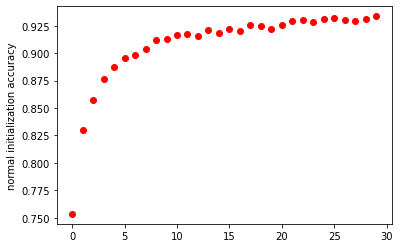

best accuracy is :  0.9337


In [12]:
plt.plot(network_normal_accuracy,'ro')
plt.ylabel('normal initialization accuracy')
plt.show()
print("best accuracy is : ",network_normal_accuracy[-1])

## Best Model from Part 1 MLP on all data accuracy : 97.8% 
## Classification based on encoded data accuracy : 93.3%